# pycalc11 and SFXC delay table comparison

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import struct
import json
import vex
import os

from astropy.time import Time, TimeDelta
from astropy import coordinates as ac
from astropy import units as un
from pycalc11 import Calc

from generate_delays import geometric_delays, extract_duration, extract_clock_offsets, extract_center_frequencies, extract_channel_mapping, save_config, parse_gps, get_offset_for_mjd
from utils.delay_file_reader import DelayFileReader
from new import plot


In [2]:
EXPER = 'B023'
SCAN = 'No0002'
SCAN_IDX = 1
DELAY_FILE_IR = 'B023_Ir.del'
DELAY_FILE_IB = 'B023_Ib.del'
VEX_PATH = '/home/matyss/Work/RADIOBLOCKS/isbi-aartfaac-tools/data/B023.vex'
OUTPUT_PATH = f'/home/matyss/Work/RADIOBLOCKS/{EXPER}/'
SUBBANDS = [3]

In [3]:
def read_delays(file, scan_index):
    reader = DelayFileReader(file)
    reader.read_file()
    scan = reader.scans[scan_index]
    delays = []
    for point in scan['points']:
        delays.append(point['delay'])
    return delays

sfxc_delays = {
    'Ib': np.array(read_delays(DELAY_FILE_IB, SCAN_IDX)),
    'Ir': np.array(read_delays(DELAY_FILE_IR, SCAN_IDX))
}

In [4]:
with open(VEX_PATH) as f:
    vex_file = vex.parse(f.read())

duration = extract_duration(vex_file, SCAN)
n_integrations = 91
g_delays, _ = geometric_delays(vex_file, SCAN, n_integrations=n_integrations)

In [5]:
x_old = np.linspace(0, 1, len(sfxc_delays['Ib']))
x_new = np.linspace(0, 1, n_integrations)

sfxc_delays['Ib'] = np.interp(x_new, x_old, sfxc_delays['Ib'])
sfxc_delays['Ir'] = np.interp(x_new, x_old, sfxc_delays['Ir'])

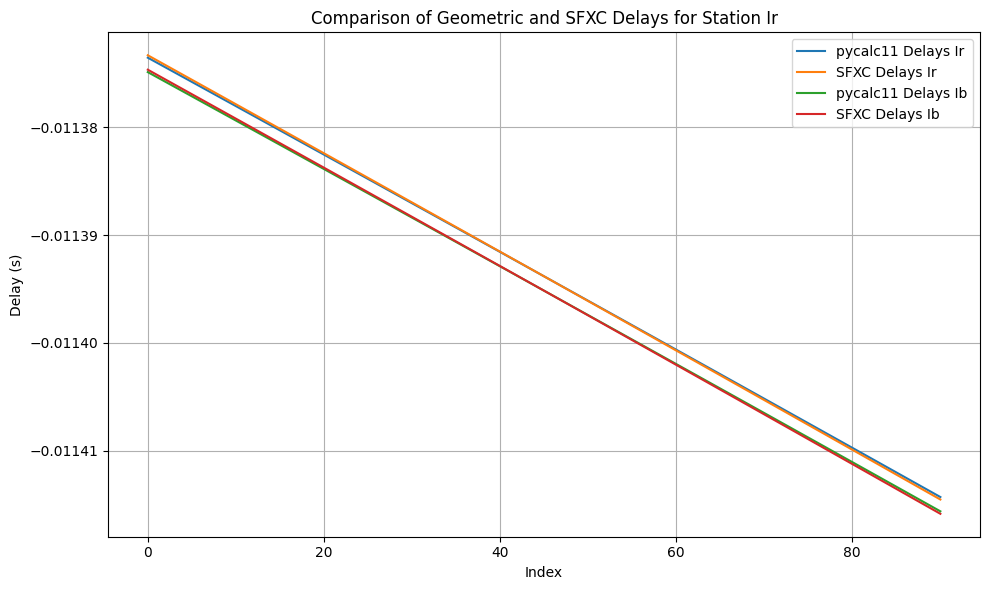

Average difference Ir = 1.1539820534584692e-09
Average difference Ib = 7.637786724431531e-10


In [6]:
plt.figure(figsize=(10, 6))
plt.plot(g_delays['Ir'], label='pycalc11 Delays Ir')
plt.plot(sfxc_delays['Ir'], label='SFXC Delays Ir', linestyle='-')
plt.plot(g_delays['Ib'], label='pycalc11 Delays Ib')
plt.plot(sfxc_delays['Ib'], label='SFXC Delays Ib', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Delay (s)')
plt.title('Comparison of Geometric and SFXC Delays for Station Ir')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f'Average difference Ir = {np.mean(g_delays["Ir"] - sfxc_delays["Ir"])}')
print(f'Average difference Ib = {np.mean(g_delays["Ib"] - sfxc_delays["Ib"])}')

In [7]:
from generate_delays import extract_start_time


clock_offsets = extract_clock_offsets(vex_file)

gps_ib = parse_gps('./gps(1).ib')
gps_ir = parse_gps('./gps(1).ir')
start_time = extract_start_time(vex_file, SCAN)
start_time_mjd = np.floor(start_time.mjd)
offset_ib = get_offset_for_mjd(gps_ib, start_time_mjd)
offset_ir = get_offset_for_mjd(gps_ir, start_time_mjd)


g_delays['Ir'] += clock_offsets['IR']
g_delays['Ib'] += clock_offsets['IB']

sfxc_delays['Ir'] += clock_offsets['IR']
sfxc_delays['Ib'] += clock_offsets['IB']

Positive value means that the antenna is ahead and negative delay should be applied.

In [8]:
delay_to_appl_to_Ir = sfxc_delays['Ir'] - sfxc_delays['Ib']
delay_in_samples = delay_to_appl_to_Ir * 32e6
delay_in_samples[0]

np.float64(46.67378237543929)

In [9]:
delay_to_appl_to_Ir = g_delays['Ir'] - g_delays['Ib']
delay_in_samples = delay_to_appl_to_Ir * 32e6
delay_in_samples[0]

np.float64(46.683712372430634)

So, we can flip the calculations in the correlator.

Instead of subtracting the reference antenna from the other antenna, we subtract the other antenna from the reference antenna.

In [10]:
delay_to_appl_to_Ir = sfxc_delays['Ib'] - sfxc_delays['Ir']
delay_in_samples = delay_to_appl_to_Ir * 32e6
delay_in_samples[0]

np.float64(-46.67378237543929)

In [11]:
delay_to_appl_to_Ir = g_delays['Ib'] - g_delays['Ir']
delay_in_samples = delay_to_appl_to_Ir * 32e6
delay_in_samples[0]

np.float64(-46.683712372430634)

In [12]:
center_frequencies = extract_center_frequencies(vex_file)
channel_mapping = extract_channel_mapping(vex_file)

selected_indices = []
for subband in SUBBANDS:
    selected_indices.extend([2 * (subband - 1), 2 * (subband - 1) + 1])

center_frequencies = [center_frequencies[i - 1] for i in SUBBANDS]
channel_mapping = [channel_mapping[i] for i in selected_indices]

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

save_config(
    f"{OUTPUT_PATH}{SCAN}.conf",
    g_delays,
    center_frequencies,
    channel_mapping
)

# TEST \#1

pycalc11 + B023.vex $CLOCK offsets

2 sec integration time

In [13]:
plot(["/home/matyss/Work/RADIOBLOCKS/isbi-aartfaac-tools/data/3_TEST"], exper=EXPER, flip=True)

Reading: /home/matyss/Work/RADIOBLOCKS/isbi-aartfaac-tools/data/3_TEST/subband_3.out
 - 88 integrations, shape: (3, 255, 4, 4)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 88) + inhomogeneous part.

# TEST \#2

pycalc11 + gps.ib and gps.ir offsets

2 sec integration time

# TEST \#3

sfxc delays + B023.vex $CLOCK offsets

as there are in total 183 values in the .del file, I had to interpolate to 91, so it matches integration time

# TEST \#4

sfxc delays + B023.vex $CLOCK offsets

1 sec integration Time